# Import preprocessed data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
plt.style.use('dark_background')


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Télécharger les stopwords pour nltk si ce n'est pas encore fait
nltk.download('punkt_tab')
nltk.download('stopwords')

# Remplacez 'chemin/vers/le/fichier.csv' par le chemin réel de votre fichier .csv
Horror_movies = pd.read_csv('data/Horror_Movies_Clean.csv')
Horror_movies = Horror_movies.rename(columns={'Weekipedia_ID': 'Wikipedia movie ID'})

# LOAD AND PROCESS ACTOR DF

character_path = os.path.join(os.getcwd(), 'data/MovieSummaries', 'character.metadata.tsv')
character_columns = [
   'Wikipedia movie ID', 'Freebase Movie ID', 'Movie release date','Character Name', 'Actor DOB', 'Actor gender', 'Actor height', 'Actor ethnicity', 
    'Actor Name', 'Actor age at movie release', 'Freebase character map1', 'Freebase character map2', 'Freebase character map3'
]
character_metadata= pd.read_csv(character_path, sep='\t', names = character_columns)

# dict that maps each freebase id with the ethnicity (from freebase website)
ethnicity_dict={
    "/m/01kb9y": "Multiracial",
    "/m/05qb937": "Venezuelans",
    "/m/09v5bdn": "Puerto Ricans",
    "/m/02pfy17": "Syrian people",
    "/m/013xrm": "Germans",
    "/m/01n94b": "Slovaks",
    "/m/02w7gg": "English people",
    "/m/0x67": "African American",
    "/m/011bn6ys": None,
    "/m/0118b8ry": None,
    "/m/03bkbh": "Irish people",
    "/m/0318mh": "Finns",
    "/m/027hhf": "Arbëreshë people",
    "/m/04c28": "Kurds",
    "/m/0cx3p": "Berbers",
    "/m/032j30": "Native Hawaiians",
    "/m/0gcp7x": "Iranian Azerbaijanis",
    "/m/013xrm": "Germans",
    "/m/038723": "Greek American",
    "/m/0d2by": "Chinese American",
    "/m/09vc4s": "English American",
    "/m/0912ll": "Dominican American",
    "/m/07mqps": "Dutch-American",
    "/m/01qhm_": "German American",
    "/m/0dbxy": "Cherokee",
    "/m/013s41": "Bulgarians",
    "/m/01km_m": "Slovenes",
    "/m/02ctzb": "White people",
    "/m/033tf_": "Irish American",
    "/m/0222qb": "Italian people",
    "/m/0jt85pd": "Greeks",
    "/m/03w9xlf": "Filipino Italian",
    "/m/0j251_s": "Arabs in France",
    "/m/0bwhd5z": "Harari people",
    "/m/0k0t_dz": "Caucasian race",
    "/m/09743": "Pashtun",
    "/m/03lmx1": "Scottish people",
    "/m/0bpjh3": "Bengalis",
    "/m/0j63_pr": "French Canadian American",
    "/m/0jt8h6f": "Latin Americans",
    "/m/02gx2x": "Javanese people",
    "/m/048z7l": "Jewish American",
    "/m/03ts0c": "French people",
    "/m/013s3n": "Czechs",
    "/m/0268_k": "Danes",
    "/m/059_w": "Native Americans in the United States",
    "/m/09kr66": "Russian American",
    "/m/0f3v0": "Comanche",
    "/m/09743": "Pashtun",
    "/m/09vc4s": "English American",
    "/m/0bpjh3": "Bengalis",
    "/m/0x67": "African American",
    "/m/0j3c70b": "Jamaicans",
    "/m/0dryh9k": "Indian people",
    "/m/09vc4s": "English American",
    "/m/0dbxy": "Cherokee",
    "/m/03bkbh": "Irish people",
    "/m/02pfy17": "Syrian people",
    "/m/0cx3p": "Berbers",
    "/m/03bkbh": "Irish people",
    "/m/02ctzb": "White people",
    "/m/02w7gg": "English people",
    "/m/033tf_": "Irish American",
    "/m/09vc4s": "English American",
    "/m/0bwhd5z": "Harari people",
    "/m/0k0t_dz": "Caucasian race",
    "/m/013xrm": "Germans",
    "/m/09743": "Pashtun",
    "/m/03w9xlf": "Filipino Italian",
    "/m/0j251_s": "Arabs in France",
    "/m/04c28": "Kurds",
    "/m/0j63_pr": "French Canadian American",
    "/m/038723": "Greek American",
    "/m/0134vqyy": "Scottish American",
    "/m/0dbxy": "Cherokee",
    "/m/05qb937": "Venezuelans",
    "/m/033tf_": "Irish American",
    "/m/03bkbh": "Irish people",
    "/m/04c28": "Kurds",
    "/m/0j251_s": "Arabs in France",
    "/m/0bpjh3": "Bengalis",
    "/m/0dbxy": "Cherokee",
    "/m/038723": "Greek American"
}

character_metadata['ethnicity_clean'] = character_metadata['Actor ethnicity'].map(ethnicity_dict)
character_metadata['Release_year'] = character_metadata['Movie release date'].astype(str).str.extract(r'(\d{4})')
character_metadata['Release_year'] = pd.to_numeric(character_metadata['Release_year'])
character_metadata = character_metadata.drop(['Movie release date', 'Actor ethnicity'], axis=1)
# replace all negative ages by nan
character_metadata['Actor age at movie release'] = character_metadata['Actor age at movie release'].where(character_metadata['Actor age at movie release'] >= 0, np.nan)

Horror_movies_with_actors = pd.merge(Horror_movies, character_metadata, on=['Wikipedia movie ID', 'Release_year'], how='left')
# for each movie, only keep the first actor
Horror_movies_with_first_actor = Horror_movies_with_actors.drop_duplicates(subset=['Name', 'Release_year'], keep='first')

def clean_movie_title(title):
    if title.startswith('#'):
        title = title[1:]
    title = title.replace('_', ' ')
    return title

# Appliquer la fonction sur la colonne 'Name'
Horror_movies_with_actors['Name'] = Horror_movies_with_actors['Name'].apply(clean_movie_title)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Analyse work occurences in titles throughout the decades

In [3]:
def analyze_word_proportions_with_highlights(df, words_to_analyze, time_intervals, 
                                             custom_palette="inferno", chart_title="Word Proportions by Decade", 
                                             show_lines=False):
    """
    Analyse les proportions des mots dans les titres de films par décennie et met en avant la décennie avec le pic.
    
    Arguments :
    - df : pd.DataFrame, DataFrame contenant les colonnes 'Name' (titres des films) et 'Release_year'.
    - words_to_analyze : list, Liste des mots à analyser.
    - time_intervals : list, Liste de tuples (start, end) définissant les tranches d'années.
    - custom_palette : str, Palette de couleurs Seaborn pour la visualisation.
    - chart_title : str, Titre du graphique.
    - show_lines : bool, Si True, ajoute des courbes sur les barres pour montrer l'évolution.
    
    Sortie :
    - Affiche un graphique montrant les proportions et les décennies de pic pour chaque mot.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from collections import Counter
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    
    stop_words = set(stopwords.words('english'))
    
    # Prétraitement des titres
    def preprocess_title(title):
        tokens = word_tokenize(title.lower())
        return [word for word in tokens if word.isalpha() and word not in stop_words]
    
    df = df.copy()  # Travailler sur une copie pour éviter de modifier l'original
    df['processed_title'] = df['Name'].apply(preprocess_title)
    
    # Calcul des proportions pour chaque intervalle
    def get_word_proportions(df, year_start, year_end, words_to_analyze):
        filtered_df = df[(df['Release_year'] >= year_start) & (df['Release_year'] <= year_end)]
        total_movies = len(filtered_df)
        word_counts = Counter()
        for title in filtered_df['processed_title']:
            word_counts.update([word for word in title if word in words_to_analyze])
        return {word: (word_counts[word] / total_movies) if total_movies > 0 else 0 for word in words_to_analyze}
    
    proportions_by_decade = {}
    for start, end in time_intervals:
        proportions_by_decade[f"{start}\n{end}"] = get_word_proportions(df, start, end, words_to_analyze)
    
    # Préparation des données pour la visualisation
    visualization_data = []
    for decade, proportions in proportions_by_decade.items():
        for word, proportion in proportions.items():
            visualization_data.append({'decade': decade, 'word': word, 'proportion': proportion})
    
    viz_df = pd.DataFrame(visualization_data)
    
    # Identifier les pics pour chaque mot
    max_decades = {}
    for word in words_to_analyze:
        word_df = viz_df[viz_df['word'] == word]
        max_decade = word_df.loc[word_df['proportion'].idxmax()]
        max_decades[word] = (max_decade['decade'], max_decade['proportion'])
    
    # Générer une palette de couleurs spécifique
    palette = sns.color_palette(custom_palette, n_colors=len(words_to_analyze))
    color_map = {word: palette[i] for i, word in enumerate(words_to_analyze)}
    
    # Visualisation
    plt.figure(figsize=(8, 8))
    ax = sns.barplot(data=viz_df, x='decade', y='proportion', hue='word', dodge=True, palette=palette, alpha=0.6)
    
    # Ajouter les annotations pour les pics
    for word, (decade, _) in max_decades.items():
        # Identifier les coordonnées du pic
        row = viz_df[(viz_df['word'] == word) & (viz_df['decade'] == decade)]
        x = row.index[0]  # Décalage du mot pour éviter de superposer
        y = row['proportion'].values[0]  # Hauteur de la barre
        
        # Trouver l'emplacement exact de la barre (utilisation des coordonnées des patches de Matplotlib)
        bar_group_idx = list(viz_df['decade'].unique()).index(decade)  # Index du groupe sur l'axe x
        bar_width = ax.patches[bar_group_idx].get_width() / len(words_to_analyze)  # Largeur individuelle d'une barre
        
        # Calcul de la position x spécifique pour le mot
        x_coord = bar_group_idx + bar_width * (words_to_analyze.index(word) - len(words_to_analyze) / 2 + 0.5)
        
        # Ajouter le mot
        plt.text(
            x=x_coord, y=y, s=word,
            ha='center', va='bottom', color='white', fontsize=12, fontweight='bold', rotation=0
        )
    
    # Ajouter les courbes si show_lines est activé
    if show_lines:
        for word in words_to_analyze:
            word_df = viz_df[viz_df['word'] == word]
            plt.plot(
                range(len(word_df['decade'])), word_df['proportion'],
                label=f"Trend: {word}", color=color_map[word], lw=3
            )
    
    plt.title(chart_title, color='white')
    plt.xlabel("Decade", color='white')
    plt.ylabel("Proportion of Movie Titles with Corresponding Word", color='white')
    plt.legend(title="Words", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, labelcolor='white')
    plt.tight_layout()
    plt.show()


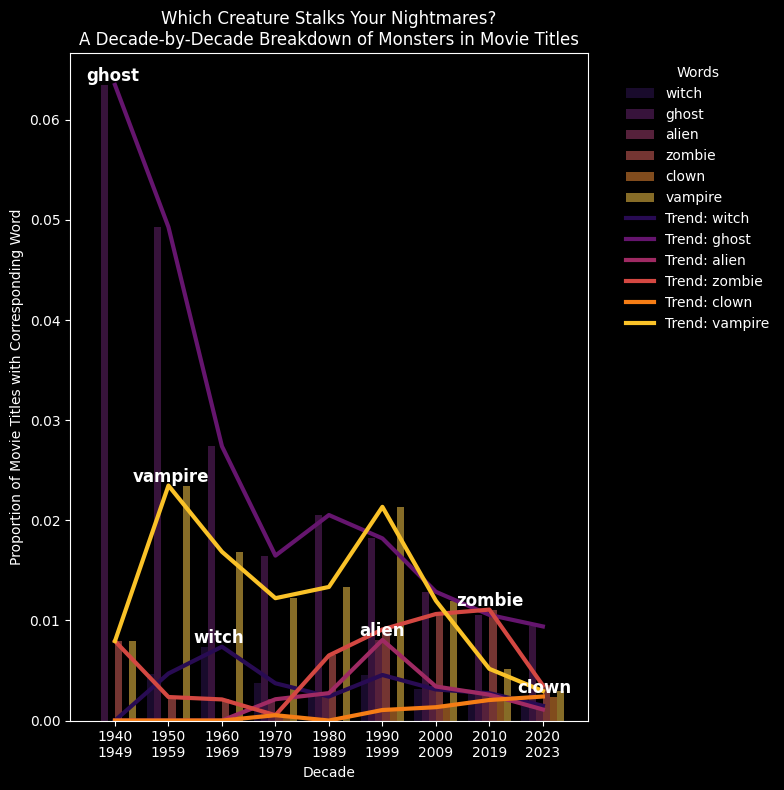

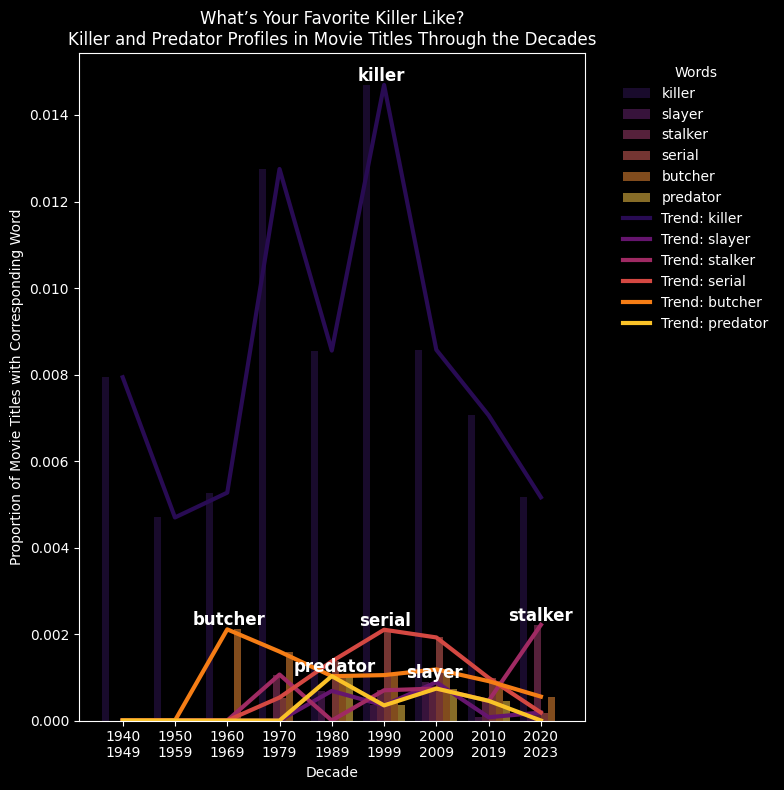

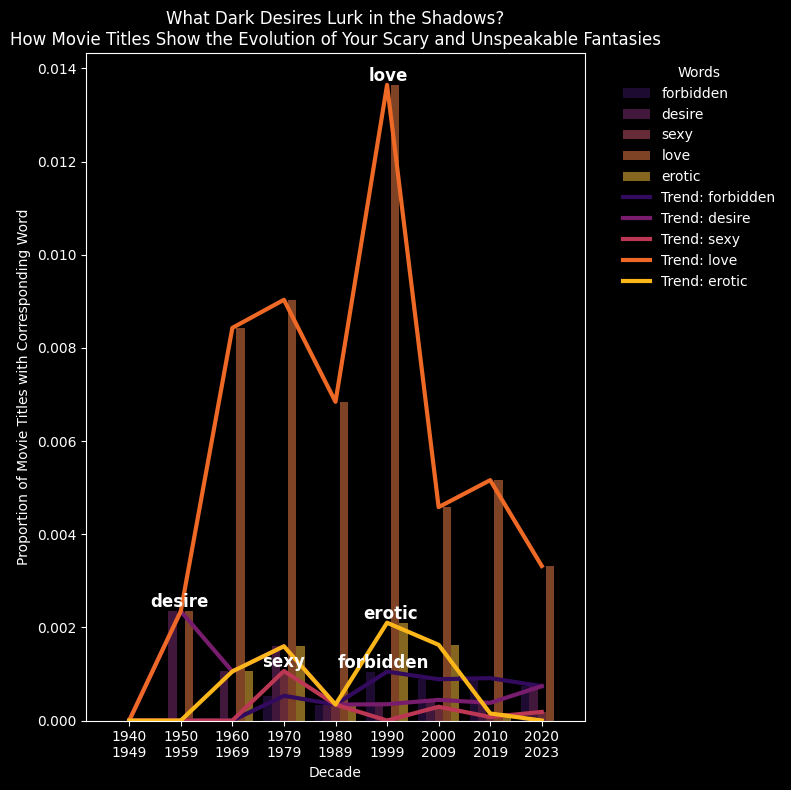

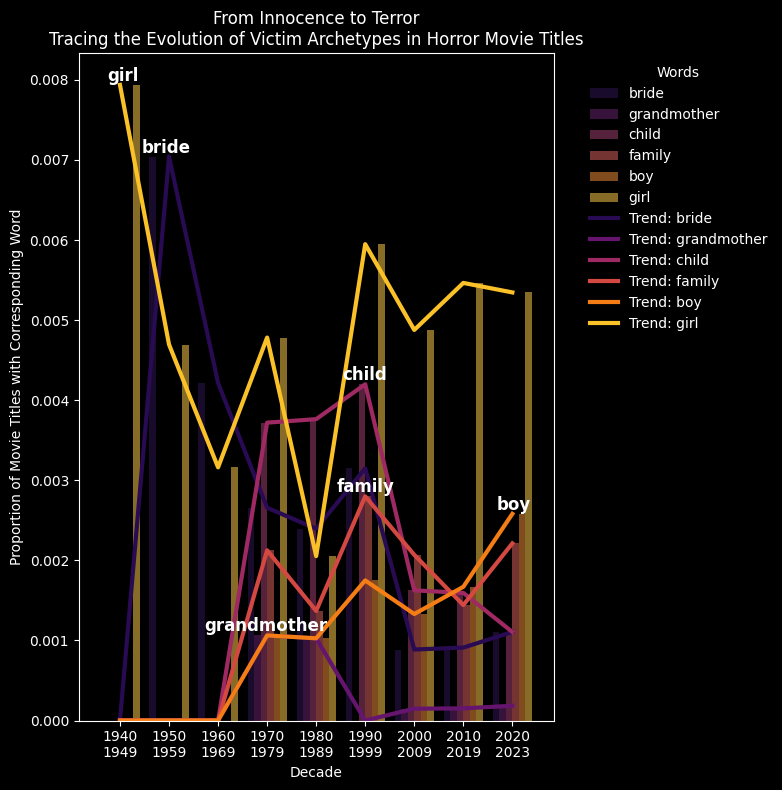

In [4]:
time_intervals = [(1940, 1949), (1950, 1959), (1960, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2009), (2010, 2019), (2020, 2023)]

analyze_word_proportions_with_highlights(Horror_movies, ['witch', 'ghost', 'alien', 'zombie', 'clown', 'vampire'], time_intervals, custom_palette='inferno', show_lines=True, chart_title="Which Creature Stalks Your Nightmares?\nA Decade-by-Decade Breakdown of Monsters in Movie Titles")

analyze_word_proportions_with_highlights(Horror_movies, ['killer','slayer', 'stalker', 'serial', 'butcher', 'predator'], time_intervals, custom_palette="inferno", show_lines=True, chart_title='What’s Your Favorite Killer Like?\nKiller and Predator Profiles in Movie Titles Through the Decades')

analyze_word_proportions_with_highlights(Horror_movies, ['forbidden', 'desire', 'sexy', 'love', 'erotic'], time_intervals, custom_palette="inferno", show_lines=True, chart_title='What Dark Desires Lurk in the Shadows?\nHow Movie Titles Show the Evolution of Your Scary and Unspeakable Fantasies')

analyze_word_proportions_with_highlights(Horror_movies, ['bride', 'grandmother', 'child', 'family', 'boy', 'girl'], time_intervals, custom_palette="inferno", show_lines=True, chart_title='From Innocence to Terror\nTracing the Evolution of Victim Archetypes in Horror Movie Titles')

# Associated words

In [5]:
import string

def analyse_association_mots(df, keyword, distance=2, stopwords=None):
    """
    Analyser les mots associés à un mot clé dans les titres de films d'horreur,
    avec une fenêtre de contexte définie autour du mot clé, tout en excluant les mots vides.
    
    Paramètres:
    - df : DataFrame avec une colonne 'Name' contenant les titres des films.
    - keyword : Le mot clé à analyser dans les titres des films.
    - distance : Le nombre de mots avant et après le mot clé à considérer (par défaut 2).
    - stopwords : Liste de mots vides à exclure (par défaut, les mots vides anglais de nltk).
    
    Retourne:
    - Un dictionnaire des fréquences des mots associés.
    - Affiche un nuage de mots.
    """
    
    # Supprimer les doublons en fonction du 'Name' et du 'Release_year'
    df = df.drop_duplicates(subset=['Name', 'Release_year'])
    
    # Utiliser les mots vides en anglais si aucun stopwords fourni
    if stopwords is None:
        stopwords = stopwords_en
    
    # Liste des caractères de ponctuation à supprimer
    punctuation = string.punctuation
    
    # Filtrer les titres contenant le mot clé
    filtered_df = df[df['Name'].str.contains(rf'\b{keyword}\b', case=False, na=False)]
    
    # Liste pour stocker les mots associés
    associated_words = []
    
    # Parcourir chaque titre pour extraire les mots voisins
    for title in filtered_df['Name']:
        # Supprimer la ponctuation du titre
        title = title.translate(str.maketrans('', '', punctuation))
        
        # Diviser le titre en mots
        words = title.lower().split()  
        for i, word in enumerate(words):
            if word == keyword:
                # Trouver la fenêtre autour du mot clé
                start = max(i - distance, 0)
                end = min(i + distance + 1, len(words))
                # Ajouter les mots voisins à la liste, exclure le mot clé et les mots vides
                for w in words[start:i] + words[i+1:end]:
                    if w not in stopwords:
                        associated_words.append(w)
    
    # Calculer la fréquence des mots associés
    word_count = pd.Series(associated_words).value_counts().to_dict()

    # Étape 3: Visualiser les résultats avec un nuage de mots
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',  # Couleur du fond
        colormap='inferno'  # Choisir la palette de couleurs
    ).generate_from_frequencies(word_count)

    # Afficher le nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Désactiver les axes
    plt.title(f'Most Recurrent Words Associated With {keyword.upper()} in Movie Titles')
    plt.show()


def filtrer_films_par_mots(df, mot1, mot2):
    """
    Filtrer les films contenant les deux mots donnés dans leurs titres,
    puis afficher le nombre de films trouvés et leurs titres de manière lisible.
    
    Paramètres:
    - df : DataFrame avec une colonne 'Name' contenant les titres des films.
    - mot1 : Le premier mot à rechercher dans les titres des films.
    - mot2 : Le deuxième mot à rechercher dans les titres des films.
    """
    
    # Supprimer les doublons en fonction du 'Name' et du 'Release_year'
    df = df.drop_duplicates(subset=['Name', 'Release_year'])
    
    # Filtrer les films qui contiennent les deux mots dans le titre (peu importe l'ordre)
    filtered_df = df[df['Name'].str.contains(rf'\b{mot1}\b', case=False, na=False) & 
                     df['Name'].str.contains(rf'\b{mot2}\b', case=False, na=False)]
    
    # Compter le nombre de films trouvés
    nombre_films = filtered_df.shape[0]
    
    # Afficher le nombre de films trouvés
    print(f"Nombre de films trouvés : {nombre_films}")
    
    # Afficher les titres des films avec l'année de sortie
    if nombre_films > 0:
        print("\nTitres des films et année de sortie :")
        for index, row in filtered_df.iterrows():
            print(f"- {row['Name']} ({row['Release_year']})")
    else:
        print("Aucun film trouvé avec les mots donnés.")
    print('---------------------------------')


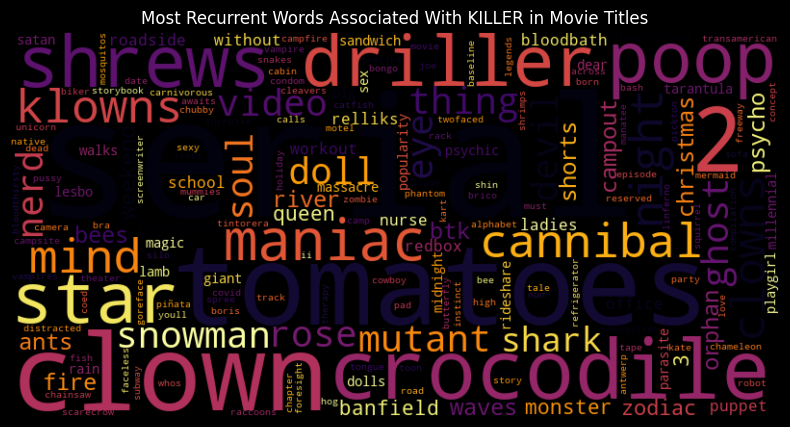

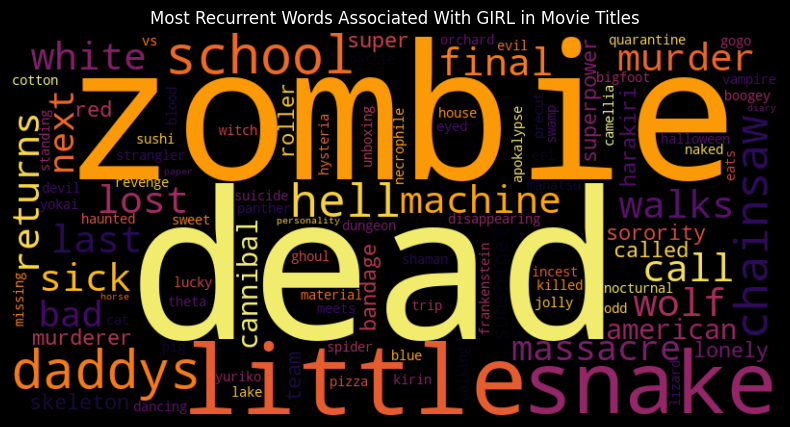

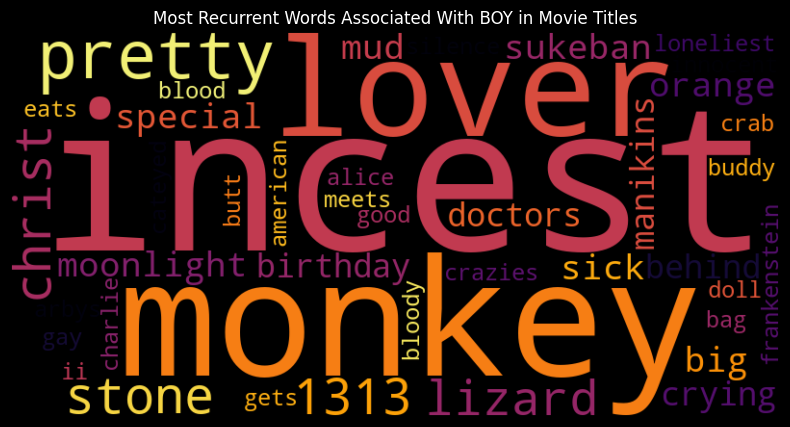

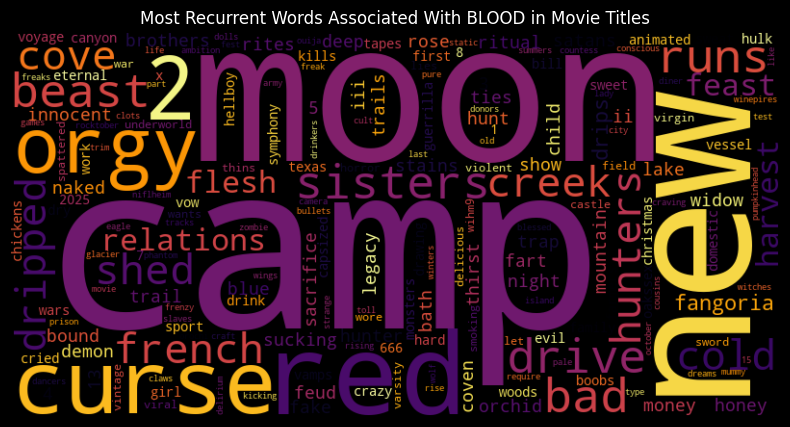

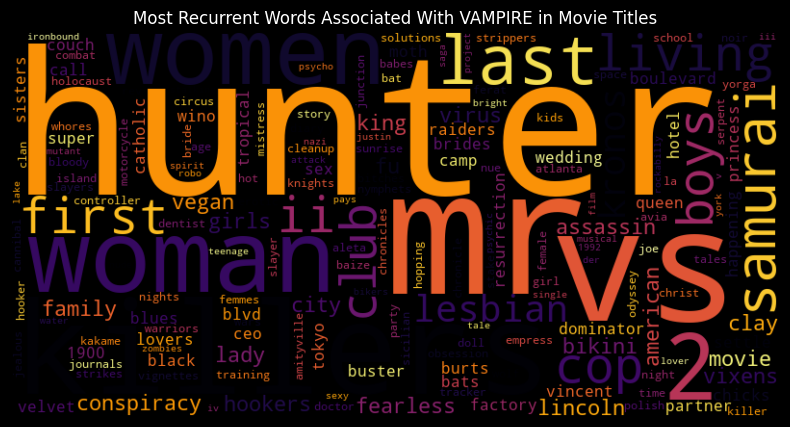

In [6]:
stopwords_en = stopwords.words('english')
from wordcloud import WordCloud


analyse_association_mots(Horror_movies, 'killer', distance=1, stopwords=None)
analyse_association_mots(Horror_movies, 'girl', distance=1, stopwords=None)
analyse_association_mots(Horror_movies, 'boy', distance=1, stopwords=None)
analyse_association_mots(Horror_movies, 'blood', distance=1, stopwords=None)
analyse_association_mots(Horror_movies, 'vampire', distance=1, stopwords=None)

# Actor profiles depending on keywords in title

In [7]:
ethnicity_groups = {
    "Occidental": [
        "Américaine", "américaine", "Américain", "Canadienne", "canadienne",
        "États-Unis", "britannique", "Britannique", "Irlandais", "Irish American",
        "Allemande", "Française", "française", "FrançaiseIrlandaise",
        "Italienne", "Italien", "Suisse", "NéerlandaiseMarocaine",
        "tchécoslovaque", "soviétiqueaméricaine", "Danes", "White people", 'Français',
        "BritanniqueAméricaine", "Jewish American", "américainefrançaise", "allemandeaméricaine",
        "Irlandaise", "italien", "italienne", "tchèque", "Norvégienne", "allemandetchécoslovaque",
        "Suédoise", "Finlandaise", "Dutch-American", "Irish people", "English people", 'CanadienAméricain', 'AllemandeIrlandaise',
        'Italian people', 'Scottish people', 'Bulgarie', 'Canadien', 'Canada', 'CanadienneAméricaine', 'AméricainePhilippine', 'Écossaise', 'allemande'
        'danoise', 'Royaume-Uni', 'Irlande', 'allemande', 'danoise ', ' danoise', "IrlandaiseAméricaine(depuis le 23 septembre 2004)"
    ],
    "Asian": [
        "Japonaise", "japonaise", "Japonais", "AméricaineTaïwanaise", "thaïlandaise",
        "Hongkongais", "Hongkongienne", "Hongkongais britannique(27 septembre 1975-30 juin 1997)chinoise(depuis le1erjuillet 1997)",
        "HongroiseAméricainenaturalisée", 'hongkongaise', 'Hong Kong britannique(27 septembre 1975-30 juin 1997)chinoise(depuis le1erjuillet 1997)',
        "Hongkongaise"
    ],
    "Africans": [
        "African American", "Sud-Africaine", "AméricaineZimbabwéenne",
        "Africans", 'Nigérian'
    ],
    "Latino-americans": [
        "Mexicaine", "péruvienne", "argentine", "Espagnole", "espagnole", "Espagne",
        "Latino-americans"
    ],
    "Australian": [
        'australienne',"Néo-zélandaise"
    ]
}



In [40]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def process_movies(df, string):
    # Filtrer le DataFrame pour ne garder que les films contenant le string dans le titre
    filtered_df = df[df['Name'].str.contains(rf'\b{string}\b', case=False, na=False)]

    print(f'Number of movies with {string}:', len(filtered_df))
    def get_first_actor(movie_name):
        base_url = "https://www.imdb.com/find?q="
        search_url = base_url + movie_name.replace(" ", "+")
        
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
        }
        
        response = requests.get(search_url, headers=headers)
        
        if response.status_code != 200:
            print(f"Erreur lors de la récupération de la page de recherche. Statut HTTP : {response.status_code}")
            return None
        
        soup = BeautifulSoup(response.text, "html.parser")
        html_string = soup.prettify()

        start_index = html_string.find('"topCredits":[')

        if start_index != -1:
            start_index += len('"topCredits":[')
            end_index = html_string.find(']', start_index)
            
            credits_string = html_string[start_index:end_index]
            credits_list = credits_string.split('","')
            
            if credits_list:
                first_actor = credits_list[0].replace('"', '')
                return first_actor

        return None

    def get_actor_details(actor_name):
        formatted_name = actor_name.replace(" ", "_")
        url = f"https://fr.wikipedia.org/wiki/{formatted_name}"
        
        try:
            response = requests.get(url)
            if response.status_code != 200:
                print(f"Erreur {response.status_code}: Impossible de trouver la page Wikipédia pour {actor_name}")
                return None, None
            
            soup = BeautifulSoup(response.text, 'html.parser')
            nationality = None
            gender = None

            for row in soup.find_all('tr'):
                header = row.find('th')
                if header:
                    if 'Nationalité' in header.get_text():
                        nationality_cell = row.find('td')
                        if nationality_cell:
                            nationality = nationality_cell.get_text(strip=True)

                    if 'Profession' in header.get_text():
                        profession_cell = row.find('td')
                        if profession_cell:
                            profession = profession_cell.get_text(strip=True).lower()
                            if 'actrice' in profession:
                                gender = 'F'
                            elif 'acteur' in profession:
                                gender = 'M'

            if not gender:
                gender_categories = soup.find_all('a', href=True)
                for category in gender_categories:
                    if 'Catégorie:Homme' in category['href']:
                        gender = 'M'
                        break
                    elif 'Catégorie:Femme' in category['href']:
                        gender = 'F'
                        break

            return nationality, gender

        except Exception as e:
            print(f"Une erreur s'est produite: {e}")
            return None, None

    def update_actor_details(row):
        print('--------------------------------')
        print(row['Name'])
        if pd.isna(row['Actor Name']) or pd.isna(row['Actor gender']) or pd.isna(row['ethnicity_clean']):
            if pd.isna(row['Actor Name']):
                first_actor = get_first_actor(row['Name'])
                if first_actor:
                    print('Found missing actor for', row['Name'], ':', first_actor)
            else:
                first_actor = row['Actor Name']
            
            if first_actor:
                nationality, gender = get_actor_details(first_actor)
                row['Actor Name'] = first_actor
                row['Actor gender'] = gender if gender else np.nan
                row['ethnicity_clean'] = nationality if nationality else np.nan
                if (gender != None) or (nationality != None):
                    print('Found missing information about', first_actor, gender, nationality)
                    print('ALL GOOD')
                else:
                    print('We know the actor but could not find info')
            else:
                row['Actor Name'] = np.nan
                row['Actor gender'] = np.nan
                row['ethnicity_clean'] = np.nan
                print('Could not find missing actor')
        else:
            print('ALL GOOD!')
        return row

    # Appliquer la fonction sur le DataFrame
    filtered_df = filtered_df.apply(update_actor_details, axis=1)

    return filtered_df

ethnicity_map = {
    "North American": [
        "Américaine", "américaine", "Américain", "African American", "German American", 
        "English American", "AméricaineCanadienne", "AméricaineItalienne(depuis 2005)[1]", 
        "AméricaineBritannique", "AméricaineAlbanaise", "Sud-africaineAméricaine", 
        "AméricaineNéerlandaise", "CubaineVénézuélienneAméricaine(depuis 2007)", 
        "MexicaineAméricaineLibanaise", "Canadienne(d'origine)Américaine(à partir de1935)", 
        "Canadienne", "États-Unis", "britanniqueAméricaine", "Irish American",
        "canadienne", "soviétiqueaméricaine", "Dutch-American", "américainefrançaise", 
        "CanadienAméricain", "Jewish American",
        "North American",
        "AméricaineRoumaineBritannique",
        "Canada",
        "AméricaineCoréenne",
        "AméricaineMexicaine",
        "CanadienneIrlandaise",
        "North American",            
        "AméricaineSud-Africaine",
        "Greek American",
        "CanadienneAméricaine",
        "AméricaineBahaméenne",
        "Americaine"
    ],
    "European": [
        "britannique", "Britannique", "BulgareCanadienne", "English people", "Française", 
        "française", "Allemande", "allemande", "BritanniqueAméricaine", "Irish people", 
        "White people", "Canadien", "Suédoise", "britanniqueaméricaine", "Australien", 
        "Écosse", "Belge", "Italienne", "TchécoslovaquepuisTchèque", "thaïlandaise", 
        "tchèque", "Néo-zélandaiseHongroise", "BritanniqueSuisse(depuis 2022)", 
        "Néo-ZélandaiseAméricaine", "PolonaisAméricain", "irlandaise", "FrançaiseAméricaine", 
        "Néerlandaise", "Italian people", "danoise", "Germans", "Royaume-Uni", 
        "italienne", "French people", "Espagnol", "espagnole", "Espagnole", 
        "HongroiseAméricainenaturalisée", "Suisse", "FrançaiseIrlandaise", "Danes", 
        "tchécoslovaque", "Espagne", "Italien", "Français", "Irlandais", "Finlandaise", 
        "allemandetchécoslovaque", "Norvégienne", "italien", "allemandeaméricaine",
        "European",
        "grecque",
        "Danoise",
        "Autrichienne",
        "Hongrois",
        "Allemande(d'origine)Américaine(naturalisée)",
        "italienneaméricaine",
        "Suède",
        "Soviétique→Russe",
        "BritanniquePakistanaise",
        "BritanniqueSierra-léonaise[1]",
        "Suédois",
        # Nouvelles entrées
        "European",              # déjà présent, on l'ajoute aussi
        "AllemandeIrlandaise",
        "IrlandaiseAméricaine(depuis le 23 septembre 2004)",
        "FrançaiseItalienne",
        "ItalienneSuédoise",
        "néerlandaise",
        "Allemand",
        "Allemagne",
        "polonaise",
        "islandaiseaméricaine",
        "suédoiseaméricaine",
        "YougoslaveItalienne",
        "Néerlandais",
        "norvégienne",
        "Irlandaise",
        "Scottish people",
        "AutrichienneAméricaine(depuis 1983)"

    ], 
    "African": [
        "African American", "Sud-africaineAméricaine", "Sud-Africaine",
        "AméricaineZimbabwéenne", "NéerlandaiseMarocaine",
        "African",
        "sud-africaine",
        "Sud-africaine"
    ],
    "Asian": [
        "japonaise", "Chinoise", "Japonaise", "hongkongaiseHong Kong britannique(?)", 
        "chinoise", "Sud-coréenne", 
        "Hong Kong britannique(27 septembre 1975-30 juin 1997)chinoise(depuis le1erjuillet 1997)", 
        "Sud-coréen", "Japonais", "japonais", "Chinois", "chinoiseHong Kong britannique", 
        "Hong Kong", "hongkongaise", "AméricaineTaïwanaise", "Hongkongais", "Hongkongaise",
        "Asian",
        "Indian people",
        "Sud-Coréenne",
        "indienne",
        "ChinoiseCanadienne",
        "sud-coréenne",
        "Hong Kong britannique(16 octobre 1950-30 juin 1996)chinoise(janvier 1997-1erseptembre 2024)",
        "Taïwanaise",
        "Indonésienne",
        "JaponaisAméricain",
        "Séoul,Sud-coréen",
        "ChinoisePhilippine",
        "Corée du Sud",
        # Nouvelles entrées
        "Asian",
        "Indien",
        "taïwanaise"
    ],
    "Latino/Hispanic": [
        "Espagnol", "mexicaine", "MexicaineAméricaineLibanaise", "Mexicain", 
        "CubaineVénézuélienneAméricaine(depuis 2007)", "Colombien", "FrançaisePortugaise",
        "argentine", "Mexicaine", "péruvienne", "  argentine",
        "MexicaineAméricaine",
        # Nouvelles entrées
        "vénézuélienne",
        "mexicaineespagnole",
        "Latino/Hispanic"
    ],
    "Middle Eastern": [
        "MexicaineAméricaineLibanaise",
        "iranienne",
        "israélienne"
    ],
    "Australian": [
        "australienne", "Australienne", "Néo-zélandaise",
        "Australian",
        "néo-zélandaise",
        "Néo-zélandais",
        "Thaïlandais(1982-2010)Australien(depuis 2010)",
        "Colonie britannique de Hong Kong",
        # Nouvelles entrées
        "Australian",
        "Nouvelle-Zélande"
    ]
}



def map_ethnicity(value):
    if value == "IrlandaiseAméricaine(depuis le 23 septembre 2004)":
                print('yes')
    if pd.isna(value):  # Si la valeur est NaN, la conserver
        return value
    for key, values in ethnicity_map.items():
        if value in values:
            return key
    return value






def plot_demographics(filtered_df, keyword):
    # Comptage du total des films
    total_movies = filtered_df['Name'].nunique()

    # Nettoyage et mappage des ethnicités
    filtered_df['ethnicity_clean'] = filtered_df['ethnicity_clean'].apply(map_ethnicity)

    # Comptage des genres et des ethnicités
    gender_counts = filtered_df.dropna(subset=['Actor gender'])['Actor gender'].value_counts()
    ethnicity_counts = filtered_df.dropna(subset=['ethnicity_clean'])['ethnicity_clean'].value_counts()

    # Diagramme pour le genre avec la palette Inferno
    # Définir la correspondance entre le genre et la couleur
    color_map = {'M': 'orange', 'F': 'purple'}

    # Extraire les couleurs en respectant l'ordre des index dans gender_counts
    colors = [color_map.get(g, 'gray') for g in gender_counts.index]
    plt.figure(figsize=(7, 7))
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    plt.title(f'Proportions of Male (M) and Female (F) Actors\nin Movies with {keyword.upper()} in the title\n'
              f'(Number of Movies: {gender_counts.sum()})')
    plt.axis('equal')  # Cercle parfait
    plt.show()

    # Diagramme pour l'ethnicité : Barres horizontales pour meilleure lisibilité
    plt.figure(figsize=(10, 8))
    sns.barplot(x=ethnicity_counts.values, y=ethnicity_counts.index, palette="inferno")
    plt.title(f'Proportion of Actor Ethnicities\nin Movies with {keyword.upper()} in the title\n'
              f'(Number of Movies: {ethnicity_counts.sum()})')
    plt.xlabel('Number of actors')
    plt.ylabel('Ethnicity')
    plt.show()

    return filtered_df['ethnicity_clean']



import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_demographics(filtered_df, keyword):
    # Comptage du total des films
    total_movies = filtered_df['Name'].nunique()

    # Nettoyage et mappage des ethnicités
    filtered_df['ethnicity_clean'] = filtered_df['ethnicity_clean'].apply(map_ethnicity)

    # Comptage des genres et des ethnicités
    gender_counts = filtered_df.dropna(subset=['Actor gender'])['Actor gender'].value_counts()
    ethnicity_counts = filtered_df.dropna(subset=['ethnicity_clean'])['ethnicity_clean'].value_counts()

    # Diagramme pour le genre avec la palette Inferno
    # Définir la correspondance entre le genre et la couleur
    color_map = {'M': 'orange', 'F': 'purple'}

    # Extraire les couleurs en respectant l'ordre des index dans gender_counts
    colors = [color_map.get(g, 'gray') for g in gender_counts.index]
    plt.figure(figsize=(7, 7))
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    plt.title(f'Proportions of Male (M) and Female (F) Actors\nin Movies with {keyword.upper()} in the title\n'
              f'(Number of Movies: {gender_counts.sum()})')
    plt.axis('equal')  # Cercle parfait
    plt.show()

    # Diagramme pour l'ethnicité : Barres horizontales pour meilleure lisibilité
    plt.figure(figsize=(10, 8))
    sns.barplot(x=ethnicity_counts.values, y=ethnicity_counts.index, palette="inferno")
    plt.title(f'Proportion of Actor Ethnicities\nin Movies with {keyword.upper()} in the title\n'
              f'(Number of Movies: {ethnicity_counts.sum()})')
    plt.xlabel('Number of actors')
    plt.ylabel('Ethnicity')
    plt.xticks(ha='center')  # Rotation des ticks pour meilleure lisibilité
    plt.show()

    # Diagramme pour l'ethnicité séparé par genre : Femmes à droite et Hommes à gauche
    # Filtrer les données pour garder uniquement les lignes où genre et ethnicité ne sont pas NaN
    filtered_gender_ethnicity = filtered_df.dropna(subset=['Actor gender', 'ethnicity_clean'])
    valid_rows_count = filtered_gender_ethnicity.shape[0]
    # Créer un graphique à barres pour chaque genre séparé par ethnicité
    plt.figure(figsize=(12, 8))
    sns.countplot(data=filtered_gender_ethnicity, x='ethnicity_clean', hue='Actor gender', palette=color_map, order=filtered_gender_ethnicity['ethnicity_clean'].value_counts().index)
    plt.title(f'Actor Ethnicities by Gender\nin Movies with {keyword.upper()} in the title\n'
              f'(Number of Movies with Non-NaN Gender and Ethnicity: {valid_rows_count})')
    plt.xlabel('Ethnicity')
    plt.ylabel('Number of actors')
    plt.xticks(ha='center')  # Rotation des ticks pour meilleure lisibilité
    plt.legend(title='Gender', loc='upper right')

    # Simplifier l'échelle des valeurs de l'axe y pour n'avoir que des entiers
    plt.tight_layout()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

    return filtered_df['ethnicity_clean']





In [10]:
vampire_df=process_movies(Horror_movies_with_first_actor, 'vampire')
witch_df=process_movies(Horror_movies_with_first_actor, 'witch')
zombie_df=process_movies(Horror_movies_with_first_actor, 'zombie')
ghost_df=process_movies(Horror_movies_with_first_actor, 'ghost')
clown_df=process_movies(Horror_movies_with_first_actor, 'clown')
alien_df=process_movies(Horror_movies_with_first_actor, 'alien')


Number of movies with vampire: 311
--------------------------------
1-900 Vampire
Found missing actor for 1-900 Vampire : David Boreanaz
Found missing information about David Boreanaz M Américaine
ALL GOOD
--------------------------------
400 Ways to Kill a Vampire
Found missing actor for 400 Ways to Kill a Vampire : Mina Edgerton
Erreur 404: Impossible de trouver la page Wikipédia pour Mina Edgerton
We know the actor but could not find info
--------------------------------
7 Sins Of The Vampire
Found missing actor for 7 Sins Of The Vampire : Darla Albornoz
Erreur 404: Impossible de trouver la page Wikipédia pour Darla Albornoz
We know the actor but could not find info
--------------------------------
A Nocturne: Night Of The Vampire
Found missing actor for A Nocturne: Night Of The Vampire : River Phoenix
Found missing information about River Phoenix None américaine
ALL GOOD
--------------------------------
A Polish Vampire in Burbank
Found missing actor for A Polish Vampire in Burbank

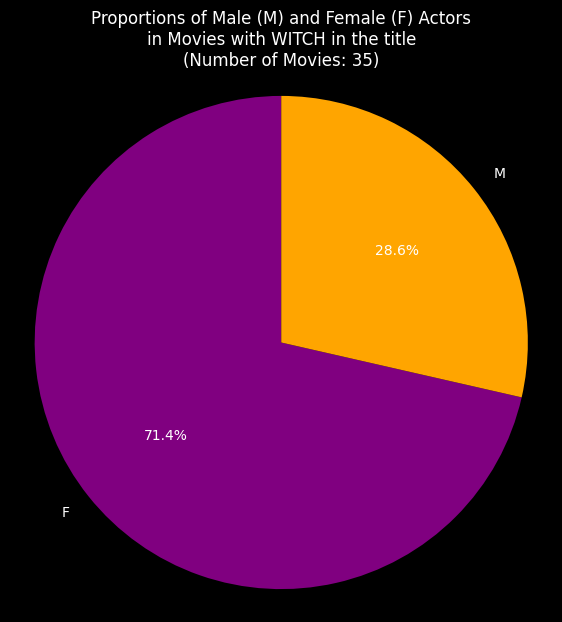

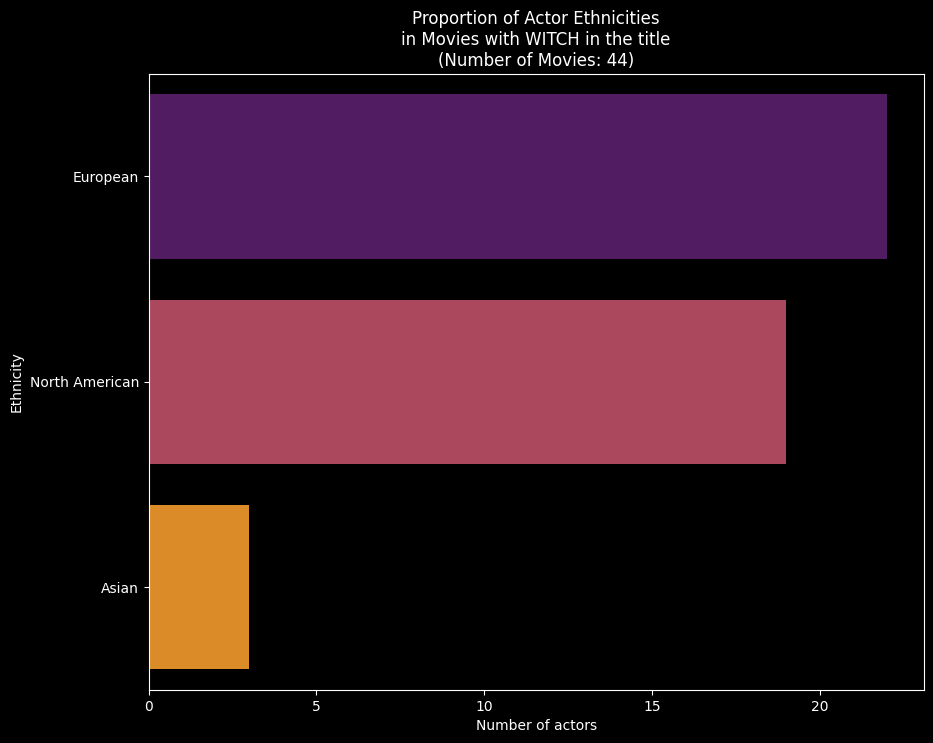

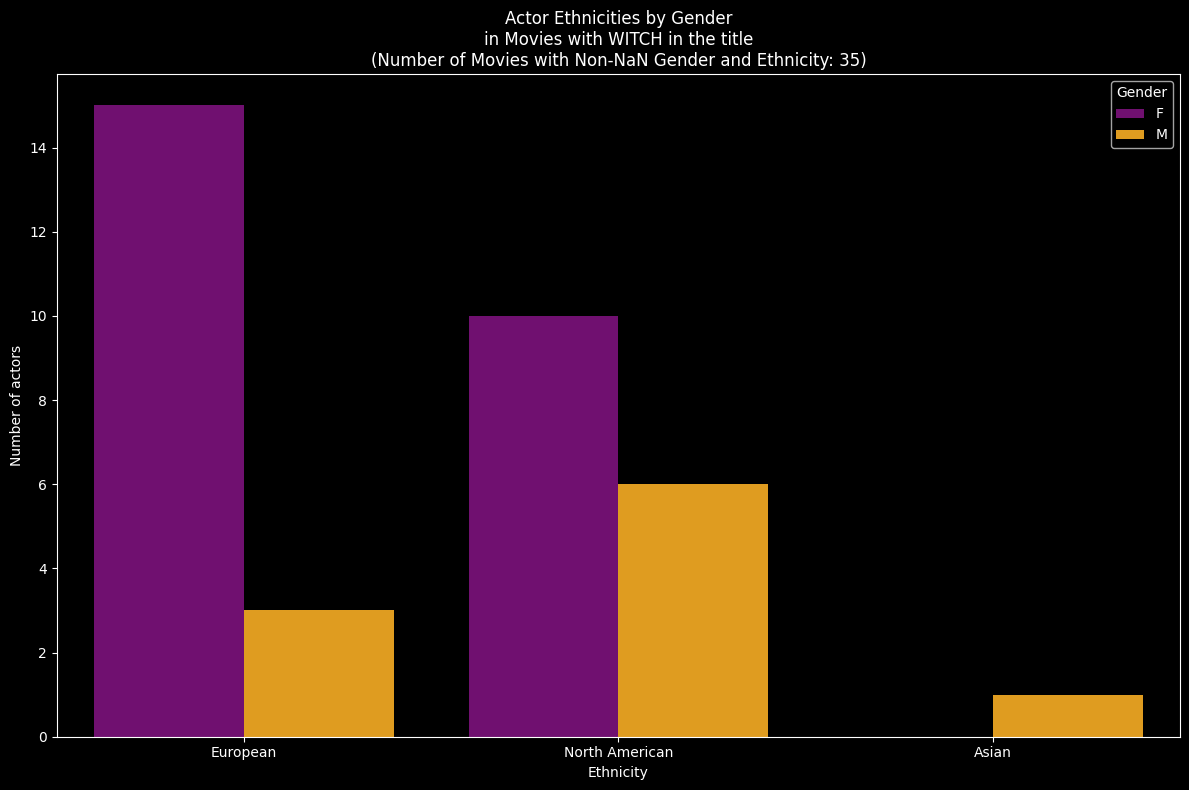

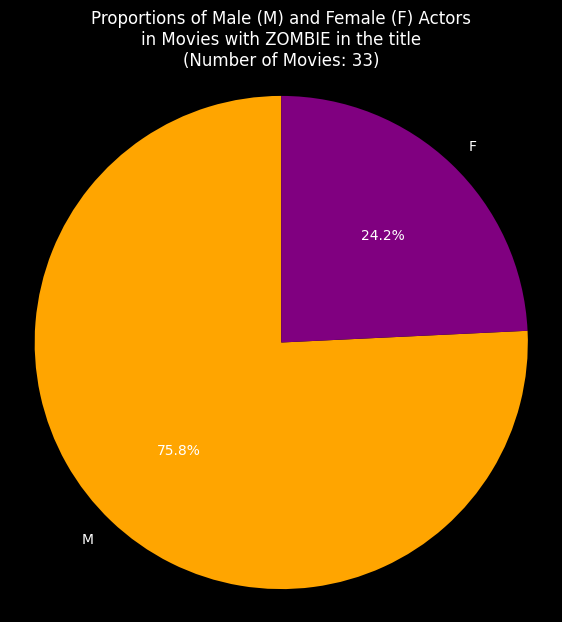

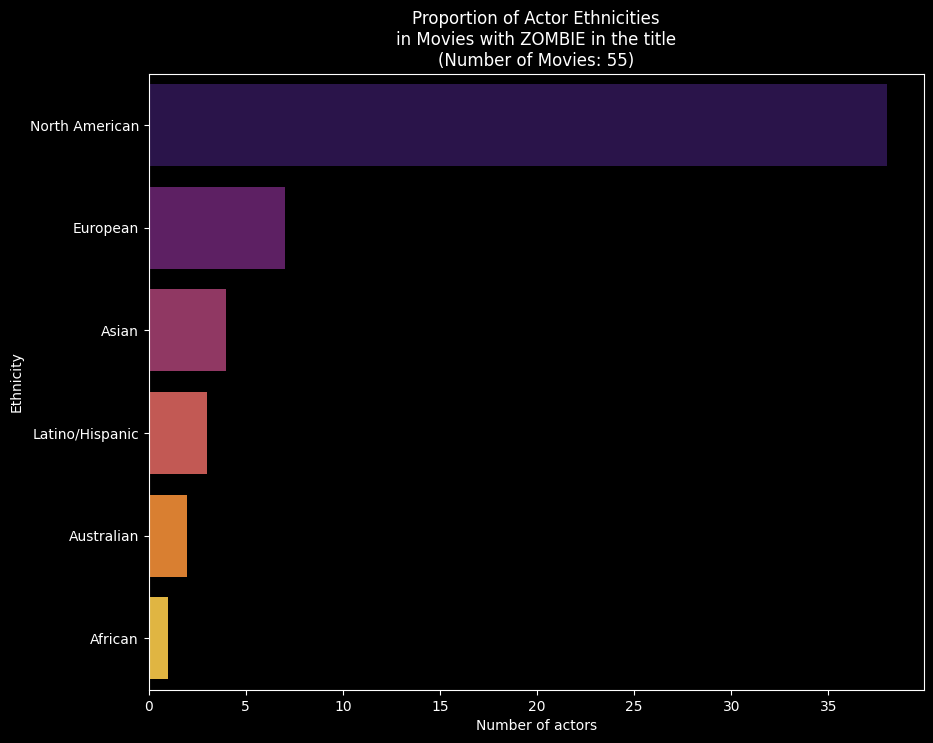

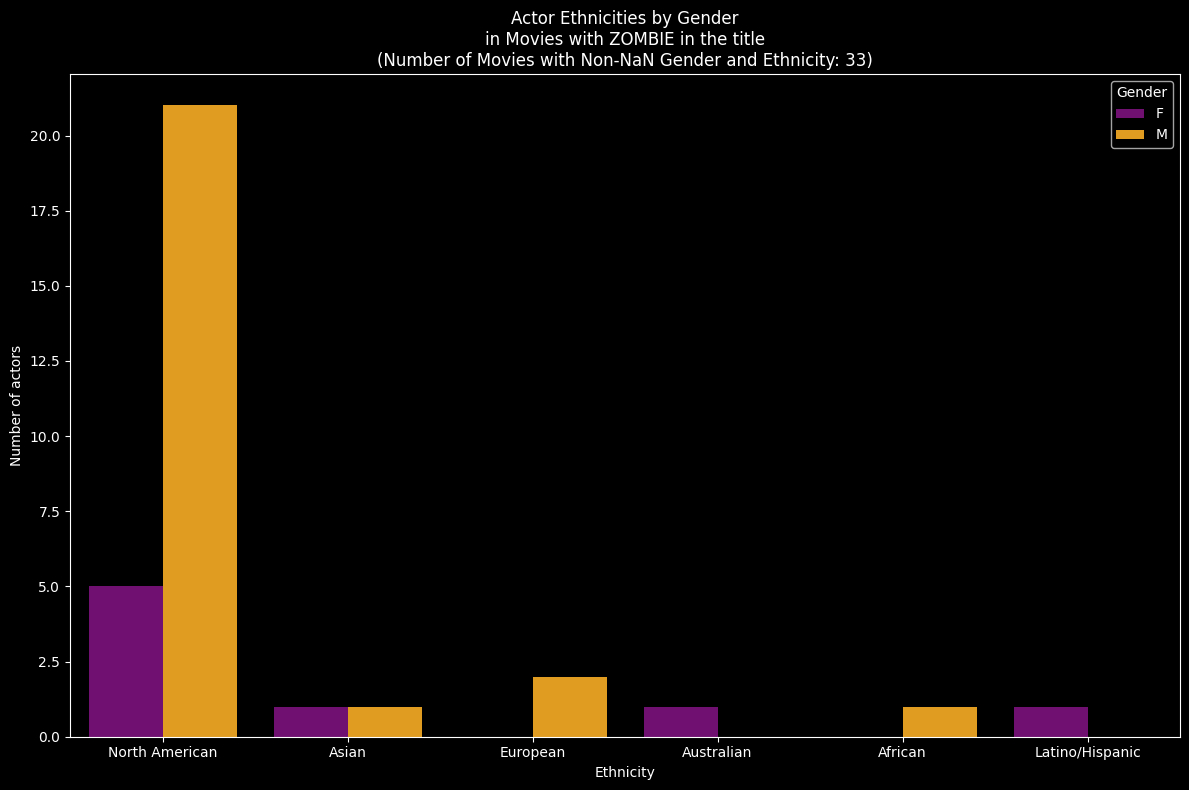

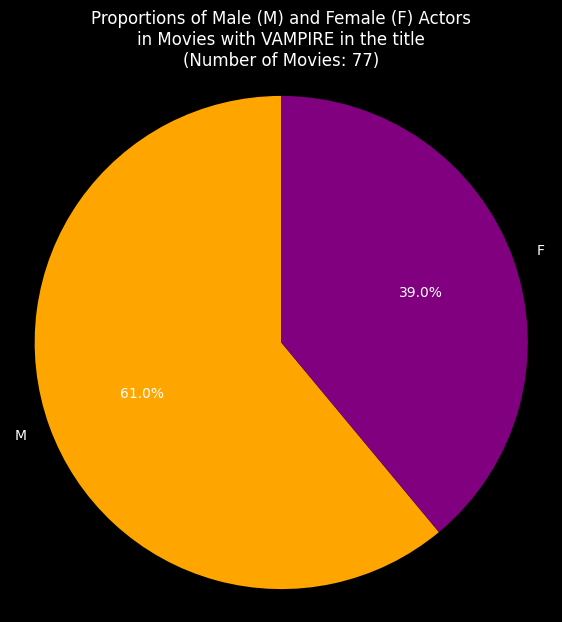

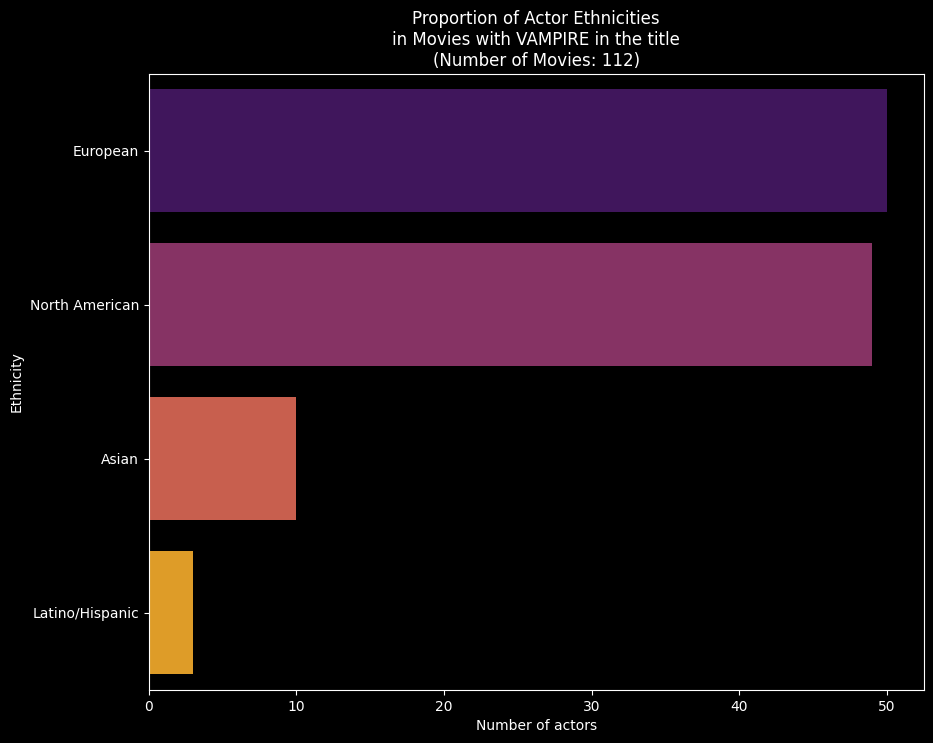

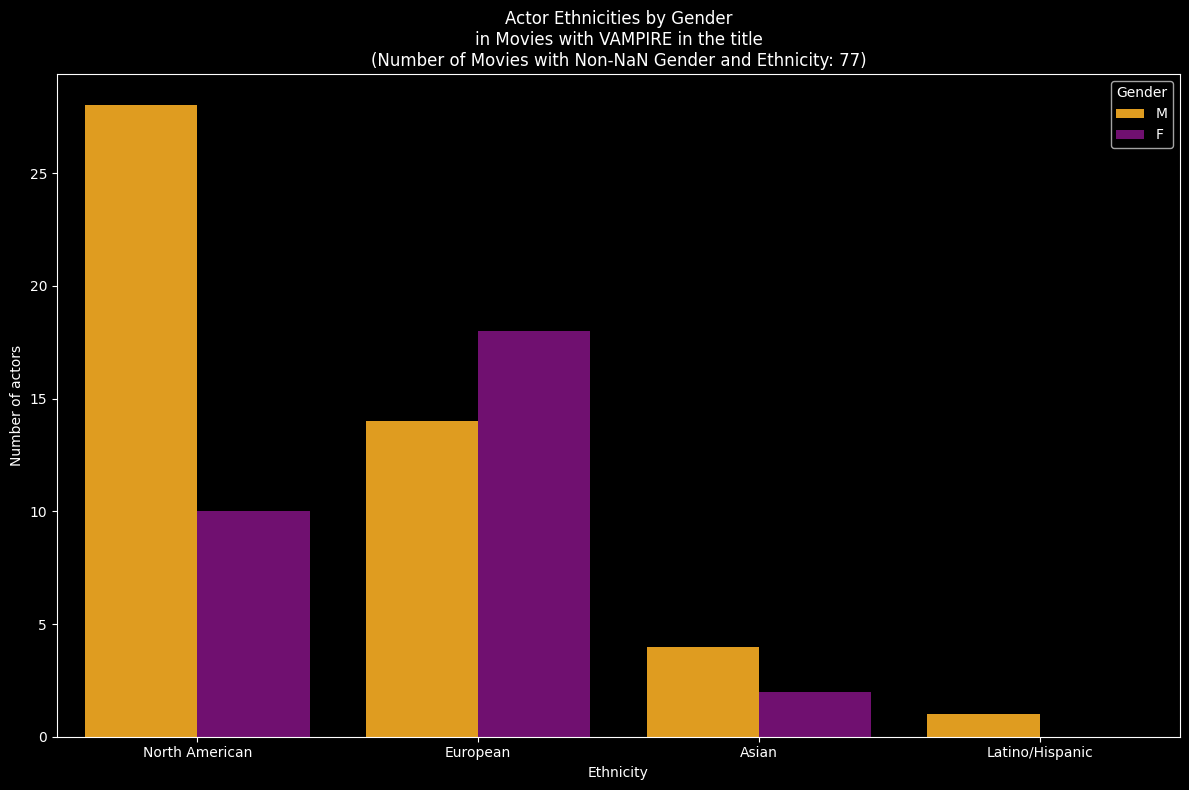

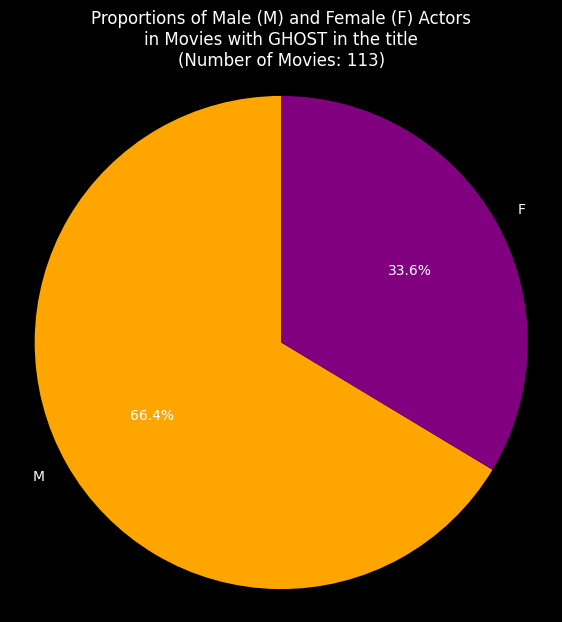

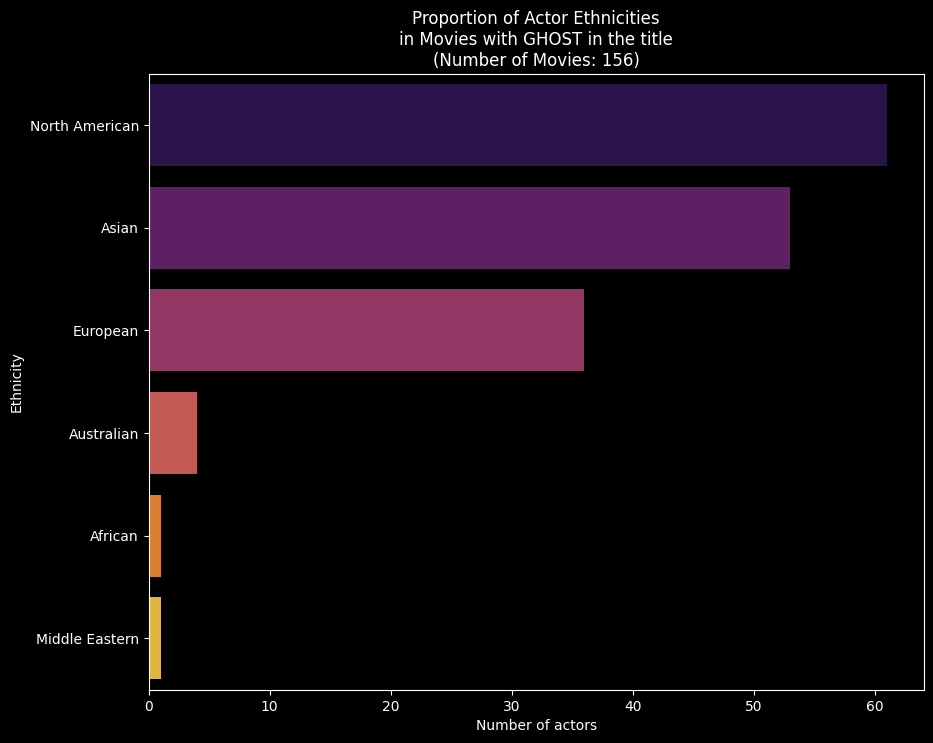

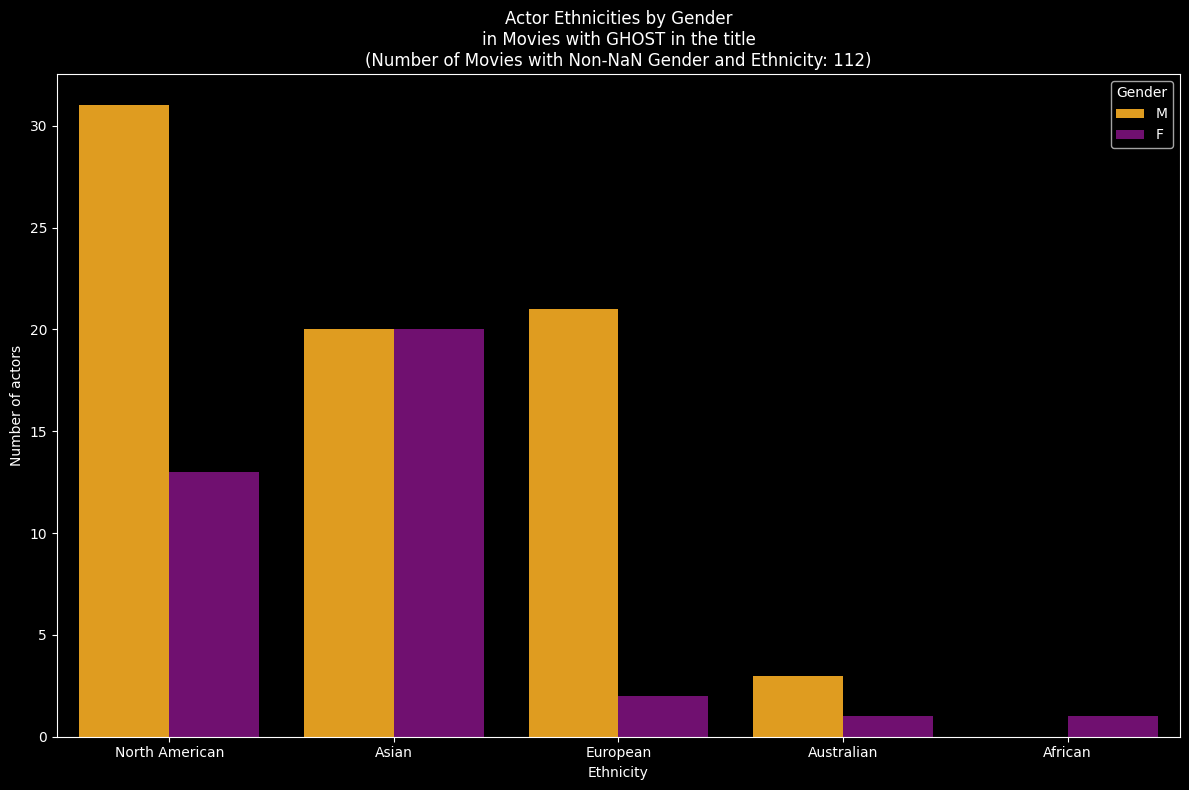

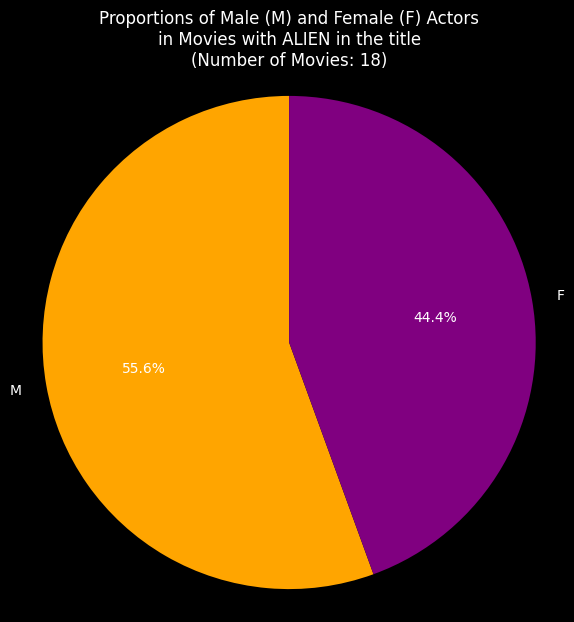

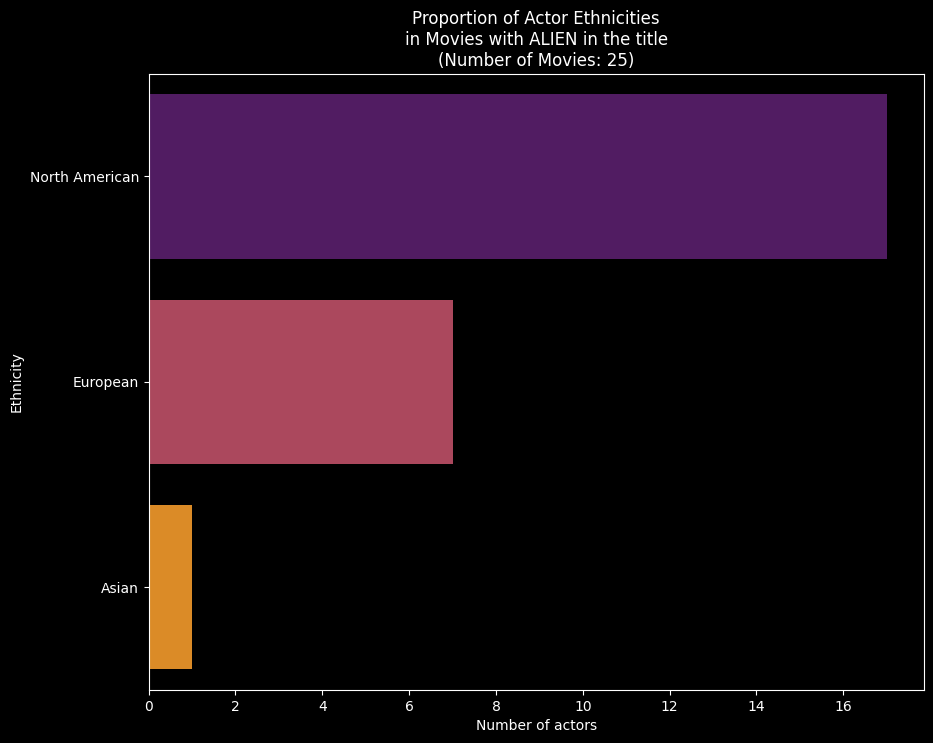

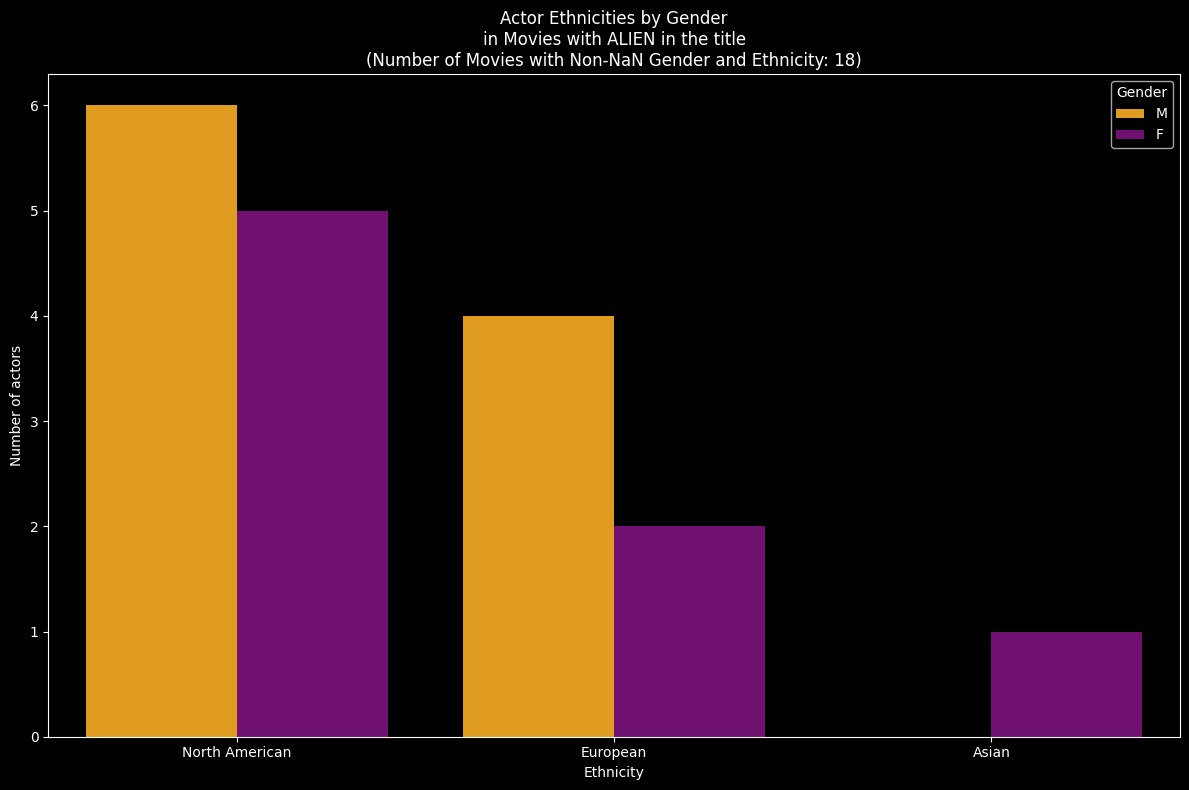

In [41]:
witch_ethnicities=plot_demographics(witch_df, 'witch')
zombie_ethnicities=plot_demographics(zombie_df, 'zombie')
vampire_ethnicities=plot_demographics(vampire_df, 'vampire')
ghost_ethnicities=plot_demographics(ghost_df, 'ghost')
alien_ethnicities=plot_demographics(alien_df, 'alien')


Number of movies with predator: 73
--------------------------------
AVP: Alien vs. Predator
ALL GOOD!
--------------------------------
AVP: Alien vs. Predator
ALL GOOD!
--------------------------------
AVP: Alien vs. Predator
Found missing information about Lance Henriksen None Américaine
ALL GOOD
--------------------------------
AVP: Alien vs. Predator
ALL GOOD!
--------------------------------
AVP: Alien vs. Predator
Found missing information about Colin Salmon M Britannique
ALL GOOD
--------------------------------
AVP: Alien vs. Predator
ALL GOOD!
--------------------------------
AVP: Alien vs. Predator
Found missing information about Agathe De La Boulaye F Française
ALL GOOD
--------------------------------
AVP: Alien vs. Predator
Found missing information about Sam Troughton M Royaume-Uni
ALL GOOD
--------------------------------
AVP: Alien vs. Predator
Found missing information about Carsten Norgaard None danoise
ALL GOOD
--------------------------------
AVP: Alien vs. Predator


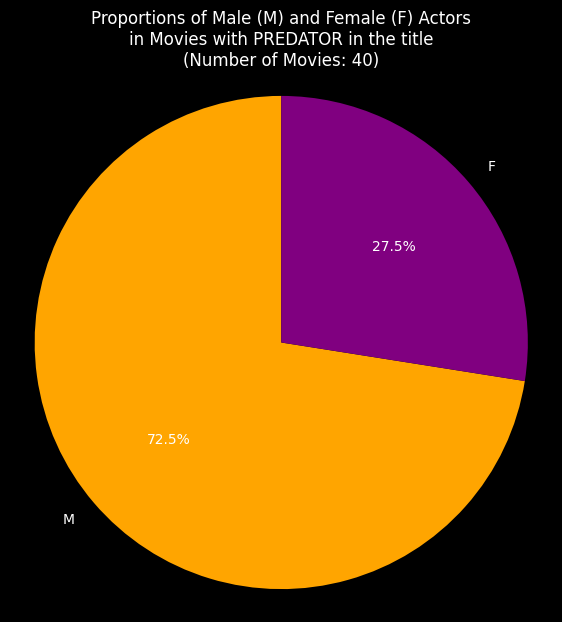

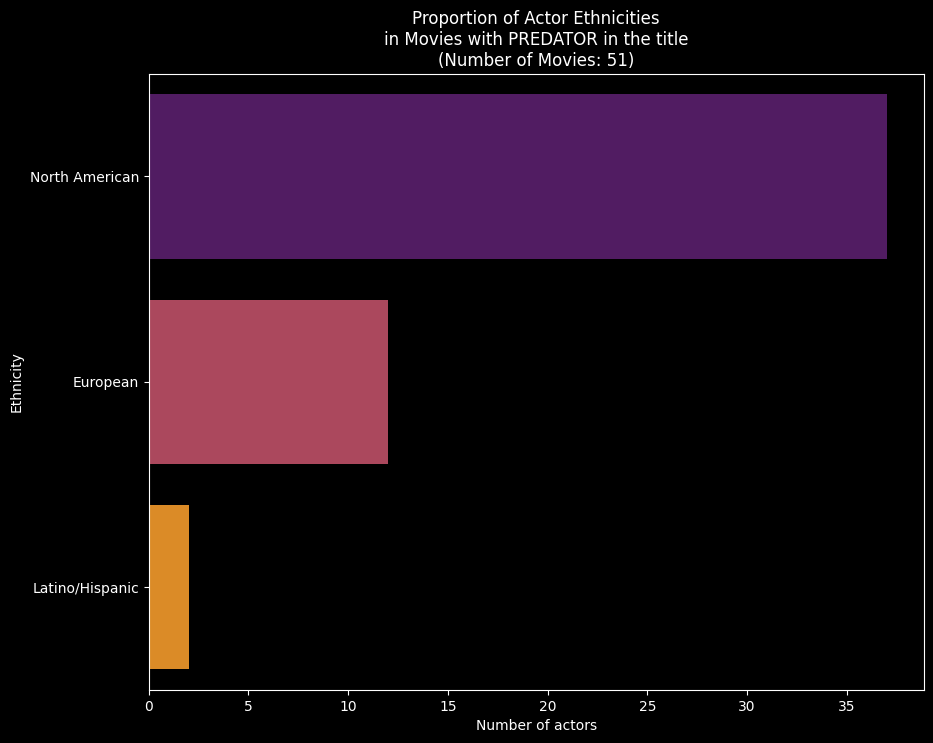

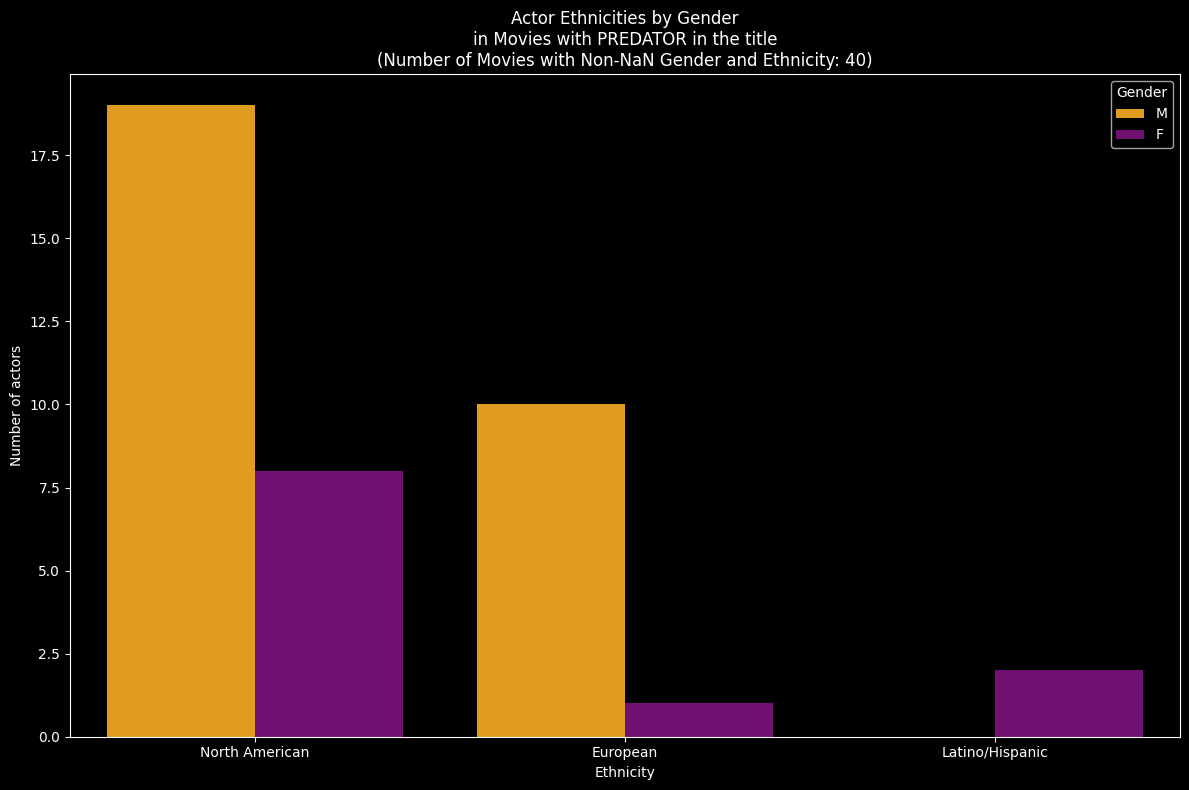

Number of movies with prey: 290
--------------------------------
Beasts of Prey
Found missing actor for Beasts of Prey : Caroline Goodall
Found missing information about Caroline Goodall F Britannique
ALL GOOD
--------------------------------
Bird Of Prey
Found missing actor for Bird Of Prey : Lenny von Dohlen
Found missing information about Lenny von Dohlen None américaine
ALL GOOD
--------------------------------
Birds of Prey
Found missing actor for Birds of Prey : Margot Robbie
Found missing information about Margot Robbie F Australienne
ALL GOOD
--------------------------------
Birds of Prey
Found missing actor for Birds of Prey : Margot Robbie
Found missing information about Margot Robbie F Australienne
ALL GOOD
--------------------------------
Cold Prey
Found missing information about Rolf Kristian Larsen None norvégienne
ALL GOOD
--------------------------------
Cold Prey
Erreur 404: Impossible de trouver la page Wikipédia pour Rune Melby
We know the actor but could not find in

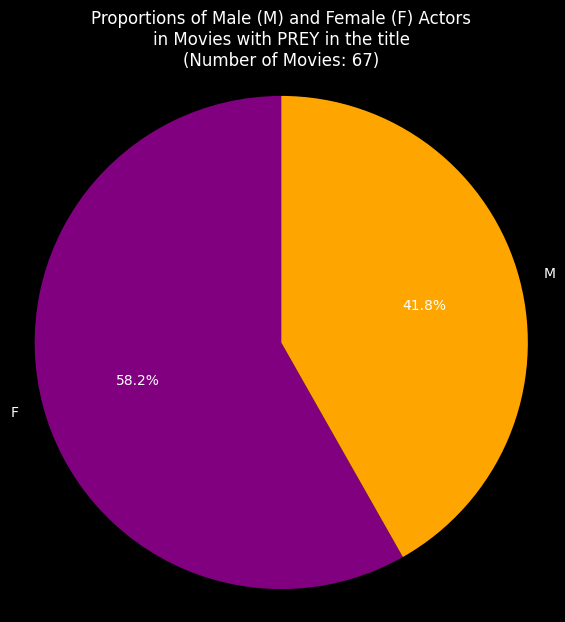

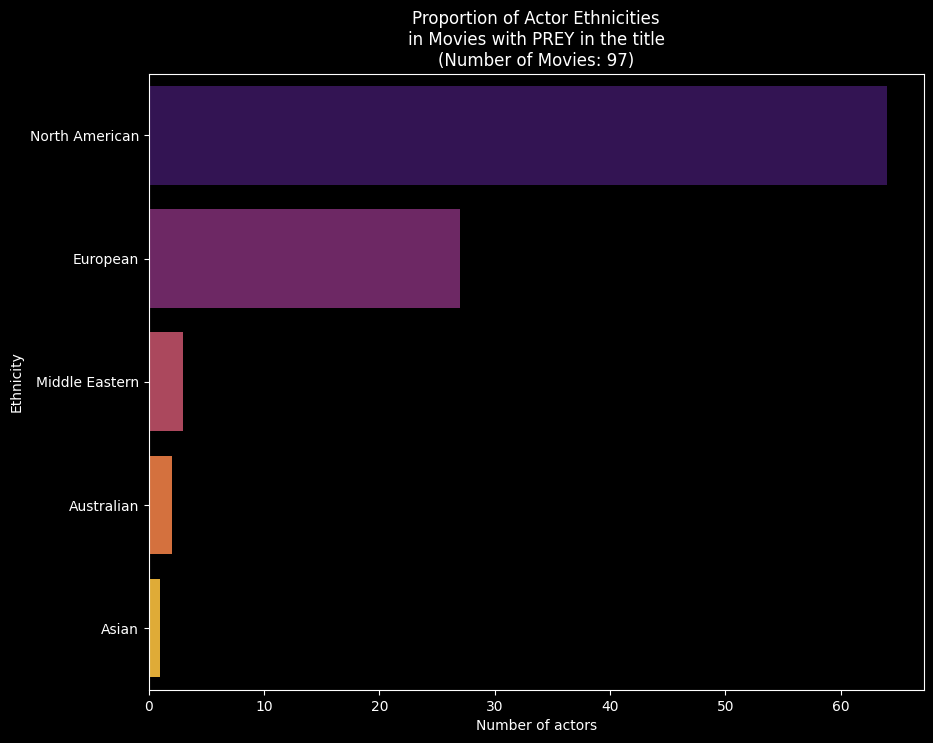

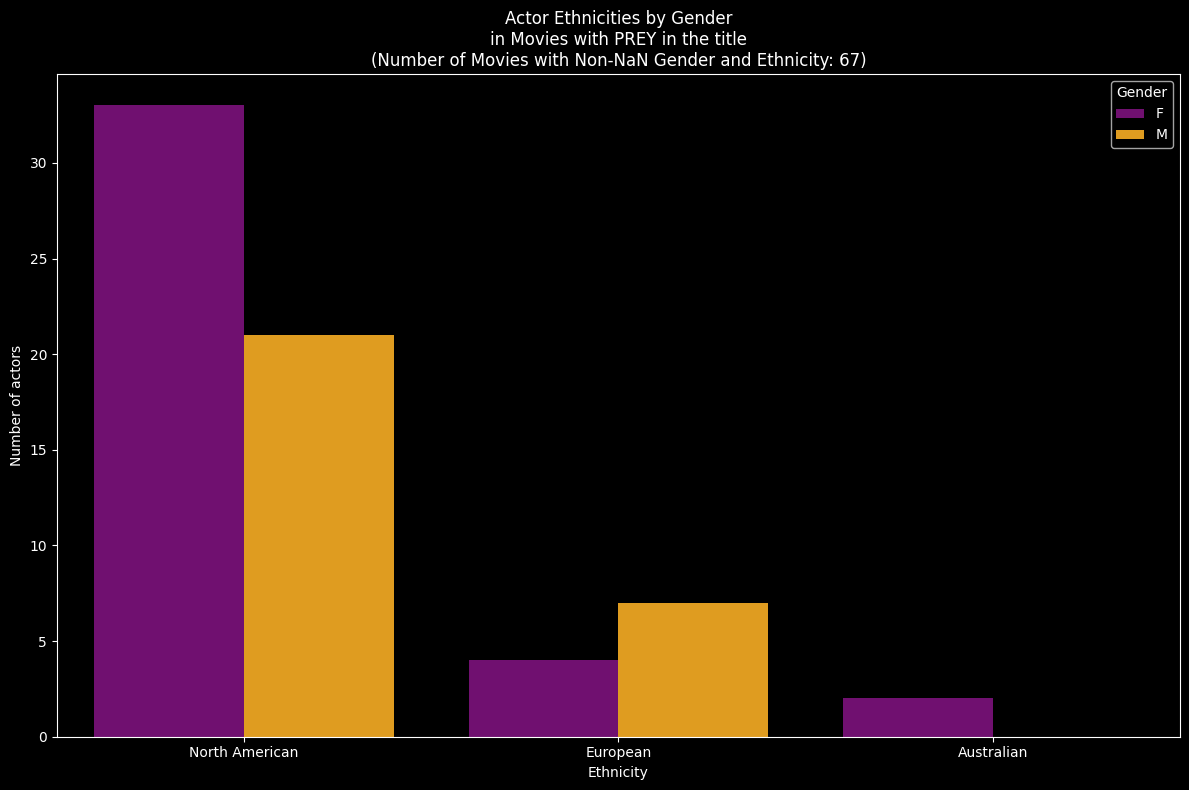

In [42]:
predator_df=process_movies(Horror_movies_with_actors, 'predator')
predator_ethnicities=plot_demographics(predator_df, 'predator')
prey_df=process_movies(Horror_movies_with_actors, 'prey')
prey_ethnicities=plot_demographics(prey_df, 'prey')